<h1>Содержание проекта<span class="tocSkip"></span></h1>

1  Загрузка и изучение данных

2  Подготовка выборок для обучения моделей

3  Обучение моделей

    3.1  LinearRegression
    3.2  CatBoostRegressor
    3.3  LightGBM

4  Анализ моделей

5  Тестирование лучшей модели

6  Общий вывод

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

# Цели и задачи проекта

**Цель проекта:** Нам нужно построить модель для определения стоимости автомобиля. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**План выполнения работ:**

1. Загрузка и изучение данных.
    - Загрузим данные, путь к файлу: /datasets/autos.csv.
    - Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков будут неинформативные, удалим их.
    

2. Подготовка выборок для обучения моделей.


3. Обучение разных моделей
    - Одна из моделей по условию задачи — LightGBM, и как минимум одна — не бустинг.
    - Для каждой модели попробуем разные гиперпараметры.
    - Если какие-то модели покажут ошибку больше чем задана в задаче, - их рассматривать далее не будем.


4. Проанализируем время обучения, время предсказания и качество моделей.
    - Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

**Дополнительная информация:**

Для оценки качества моделей применяйте метрику RMSE.

Значение метрики RMSE должно быть меньше 2500. Соответственно, если на этапе обучение какие-то модели не уложатся в поставленные условия - мы не будем их рассматривать.

## Загрузка и изучение данных

In [2]:
#импорты настройки функции

import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})

from matplotlib import pyplot as plt

from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
    
# для оценки времени
from tqdm.auto import tqdm
import time

# остальное
import warnings
warnings.filterwarnings('ignore')

# функция для графика ящик с усами
def sns_boxplot(dt, chart_title):
    sns.boxplot(x=dt)
    plt.title(chart_title)
    plt.show();

Загрузим файл и посмотрим на данные.

In [3]:
data = pd.read_csv("/datasets/autos.csv")
origin_data = data.copy()
origin_len = len(data)

In [4]:
display(data.head())
print()
print(data.info())
print()
print('Полных дубликатов:', sum(data.duplicated()))
#display(data.loc[data.duplicated()])
print()
print('Describe:')
display(data.describe())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Имеем следующий набор данных:**

**Признаки**  
  - `DateCrawled` — дата скачивания анкеты из базы  
  - `VehicleType` — тип автомобильного кузова  
  - `RegistrationYear` — год регистрации автомобиля  
  - `Gearbox` — тип коробки передач  
  - `Power` — мощность (л. с.)  
  - `Model` — модель автомобиля  
  - `Kilometer` — пробег (км)  
  - `RegistrationMonth` — месяц регистрации автомобиля  
  - `FuelType` — тип топлива  
  - `Brand` — марка автомобиля  
  - `Repaired` — была машина в ремонте (yes) или нет (no)
  - `DateCreated` — дата создания анкеты  
  - `NumberOfPictures` — количество фотографий автомобиля  
  - `PostalCode` — почтовый индекс владельца анкеты (пользователя)  
  - `LastSeen` — дата последней активности пользователя  
    
**Целевой признак**  
  - `Price` — цена (евро)  
  
И сразу можно отметить, что:

- судя по describe в признаке RegistrationYear есть аномальные значения,

- в RegistrationMonth откуда-то взялся ноль, при том что максимум 12 (т.е. нумерация месяцев должна быть либо 0-11 либо 1-12),

- в признаке Power максимальная мощность 20000 л.с., это явно аномальное значение.

- Полных дубликатов всего 4, так что их можно удалить.

In [5]:
data.drop_duplicates(inplace=True)
print('Полных дубликатов теперь:',data.duplicated().sum())

Полных дубликатов теперь: 0


**Наша основная задача - это прогнозировать цену на авто, соответственно**

**Как мы видим сразу можно удалить признаки, которые не могут влиять на стоимость авто:**

- NumberOfPictures
- PostalCode
- LastSeen
- DateCrawled
- DateCreated

In [6]:
data.drop(['NumberOfPictures', 'PostalCode', 'LastSeen', 
         'DateCrawled', 'DateCreated'], axis=1, inplace=True)

Теперь посмотрим на признак месяца регистрации авто:

In [7]:
rm_0 = data.loc[data['RegistrationMonth']==0,'RegistrationMonth'].count()
print(f'Месяц записан как ноль: {rm_0/origin_len:.2%} датасета.')

rm_1 = data.loc[data['RegistrationMonth']==1,'RegistrationMonth'].count()
print(f'Месяц записан как единица: {rm_1/origin_len:.2%} датасета.')

rm_12 = data.loc[data['RegistrationMonth']==12,'RegistrationMonth'].count()
print(f'Месяц записан как двенадцать: {rm_12/origin_len:.2%} датасета.')

Месяц записан как ноль: 10.54% датасета.
Месяц записан как единица: 6.55% датасета.
Месяц записан как двенадцать: 6.85% датасета.


Невозможно удалить 10.5 или 6.8 процентов датасета просто из предположения что неправильно указан месяц.

При этом пользы от такого признака, с учетом того что мы не знаем как его будут указывать в дальнейшем - мало.

Избавимся от признака RegistrationMonth чтобы не было путаницы.

In [8]:
data.drop(['RegistrationMonth'], axis=1, inplace=True)

**Посмотрим на пропуски:**

In [9]:
data.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

**Признак model является одним из основных, влияющих на цену.**

Посмотрим сколько данных пропущено в нем:

In [10]:
print(f"Всего с незаполненной моделью: {len(data.loc[data['Model'].isna()])/origin_len:.2%} датасета.")

Всего с незаполненной моделью: 5.56% датасета.


Мы бы могли удалить эти данных, хотя их и чуть больше 5%, но т.к. мы и другие признаки "чистим", то пока заполним модель значением неизвестно, чтобы не терять полезных данных из др. признаков.

In [11]:
data['Model'] = data['Model'].fillna('unknown')

**Посмотрим на признак Repaired:**

In [12]:
data['Repaired'].value_counts()

no     247158
yes     36053
Name: Repaired, dtype: int64

Заполним пропуски в признаке Repaired исходя из предположения, что если не указано, значит и не была машина в ремонте.

In [13]:
data['Repaired'] = data['Repaired'].fillna('no')

И так как либо была либо не была, поменяем тип столбца на bool:

In [14]:
data.loc[(data['Repaired'] == 'yes'), 'Repaired'] = 1
data.loc[(data['Repaired'] == 'no'), 'Repaired'] = 0
data['Repaired'] = data['Repaired'].astype(bool)
data['Repaired'].value_counts()

False    318312
True      36053
Name: Repaired, dtype: int64

**Посмотрим на признаки VehicleType, FuelType и Gearbox:**

Они могут быть не заполнены просто потому что не заполняли если не самое популярное. Т.е. например, если коробка автомат заполняли, а если ручная то не заполняли данные. Либо же данные были утеряны или просто не заполнены.

Попробуем заполнить эти признаки исходя из логики.

**Попробуем заполнить VehicleType исходя из данных Model**

Т.е. предположим, что тип авто у одной и той же модели такой же.

In [15]:
# заполняем VehicleType исходя из самого популярного типа по данной модели
data['VehicleType'] = data['VehicleType'].fillna(data
                                                  .groupby('Model')['VehicleType']
                                                  .transform(lambda x: x.value_counts().idxmax())
                                                 )

**А вот коробка, у того же VW Golf могла быть и автомат и ручная, тоже касается и типа топлива.**

Т.е. тут мы не можем опираться на модель авто. Поэтому заполним пропуски в этих признаках значением неизвестно.

In [16]:
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['FuelType'] = data['FuelType'].fillna('unknown')

**И снова посмотрим на пропуски в датасете:**

In [17]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Пропусков нет, теперь приведем названия столбцов к snake_case.

In [18]:
data.columns = data.columns.str.lower()

columns = {'registrationyear':'registration_year', 
           'vehicletype':'vehicle_type', 
           'fueltype':'fuel_type'}

data.rename(columns=columns, inplace=True)

data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

**Перейдем к анализу и обработке аномальных значений.**

In [19]:
data.describe()

,price,registration_year,power,kilometer
count,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989
std,4514.176349,90.228466,189.851330,37905.083858
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Сначала обработаем второстепенные признаки, а затем уже посмотрим на price, чтобы не удалить лишнего.

**Признак год регистрации:**


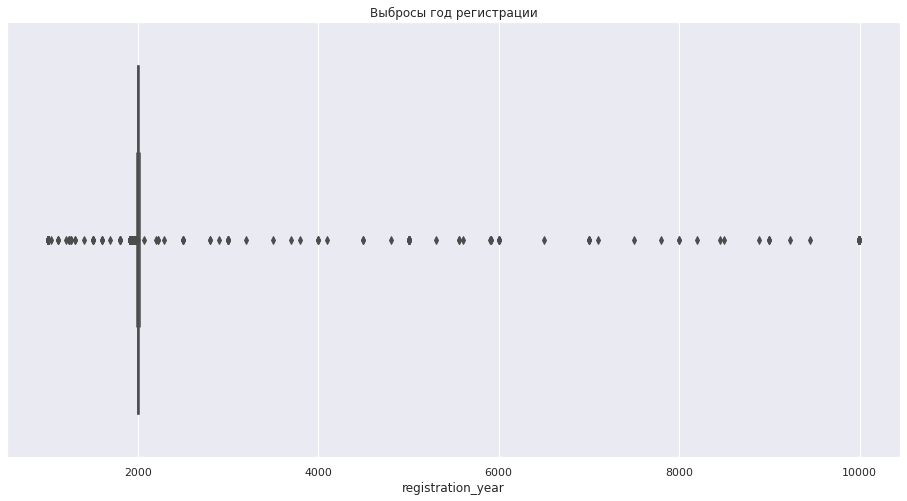

In [20]:
sns_boxplot(data['registration_year'],'Выбросы год регистрации')

In [21]:
data['registration_year'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [22]:
r_y_q01 = data["registration_year"].quantile(0.01)
print(f'Квантиль 0.01 год регистрации:{r_y_q01}, все годы что меньше - удаляем.')
print(f'Строк где год < {r_y_q01}: {data.query("registration_year<@r_y_q01").shape[0]}')
data.drop(data.loc[data['registration_year']<r_y_q01].index, inplace=True)
print('Удалено.')

Квантиль 0.01 год регистрации:1980.0, все годы что меньше - удаляем.
Строк где год < 1980.0: 3452
Удалено.


**Ограничим год регистрации "сверху" опираясь на данные признака DateCrawled**

Посмотрим, какая максимальная дата скачивания анкеты:

In [23]:
origin_data.sort_values(by='DateCrawled').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
329497,2016-03-05 14:06:22,150,small,1997,manual,75,polo,150000,4,petrol,volkswagen,no,2016-03-05 00:00:00,0,35789,2016-03-27 17:16:15
220583,2016-03-05 14:06:23,3999,wagon,2003,manual,220,a6,150000,7,petrol,audi,no,2016-03-05 00:00:00,0,57080,2016-03-06 18:29:35
176823,2016-03-05 14:06:24,6200,convertible,2006,manual,135,megane,90000,9,petrol,renault,no,2016-03-05 00:00:00,0,35764,2016-03-24 09:16:44
99885,2016-03-05 14:06:24,10900,suv,2003,auto,245,NaN,150000,11,petrol,sonstige_autos,no,2016-03-05 00:00:00,0,56072,2016-04-06 22:15:33
324763,2016-03-05 14:06:24,799,small,1997,manual,60,polo,150000,11,petrol,volkswagen,no,2016-03-05 00:00:00,0,35708,2016-03-09 15:19:01


Как видим, это 2016 год. Соответственно, всё что больше - убираем.

In [24]:
print(f'Строк где год > 2016: {data.query("registration_year>2016").shape[0]}')
data.drop(data.loc[data['registration_year']>2016].index, inplace=True)
print('Удалено.')

Строк где год > 2016: 14530
Удалено.


И еще раз посмотрим на данных признака:

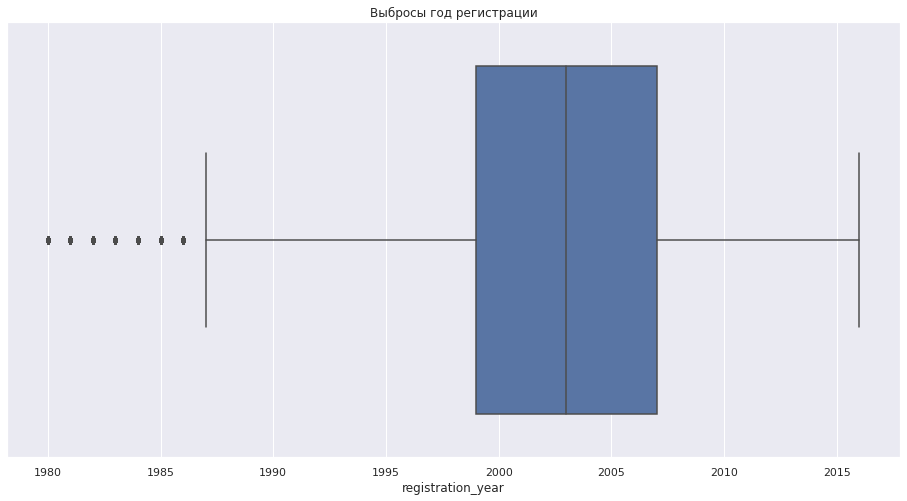

count    336383.000000
mean       2002.828912
std           6.082015
min        1980.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

In [25]:
sns_boxplot(data['registration_year'],'Выбросы год регистрации');
data['registration_year'].describe()

Избавились от выбросов в признаке, при этом почти не потеряли данные. Переходим к сл. признаку.

**Признак мощность авто:**

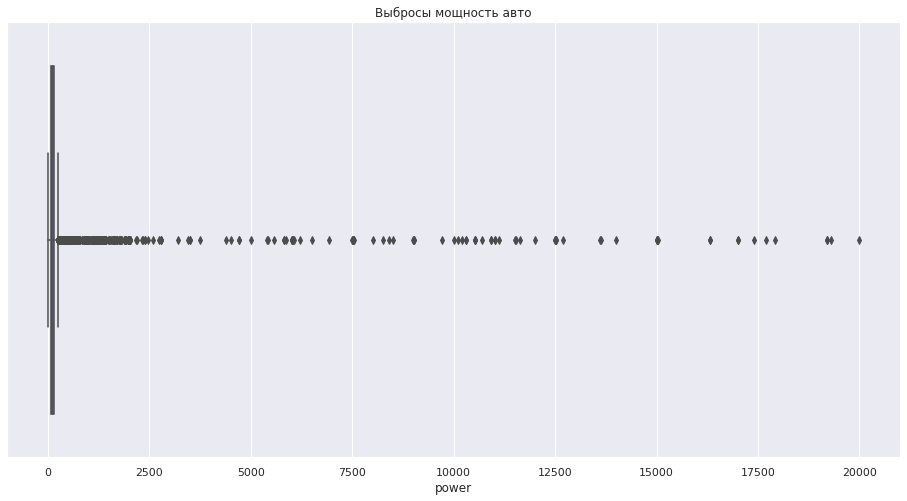

count    336383.000000
mean        111.366439
std         185.511186
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [26]:
sns_boxplot(data['power'],'Выбросы мощность авто');
data['power'].describe()

Посмотрим сколько данных у нас с мощностью > .995 квантиля

Квантиль 0.995 мощность:334.0
Строк где мощность > 334.0: 1649, всего 0.47% от ориг. датасета, удаляем.
Снова посмотрим на график выбросов:


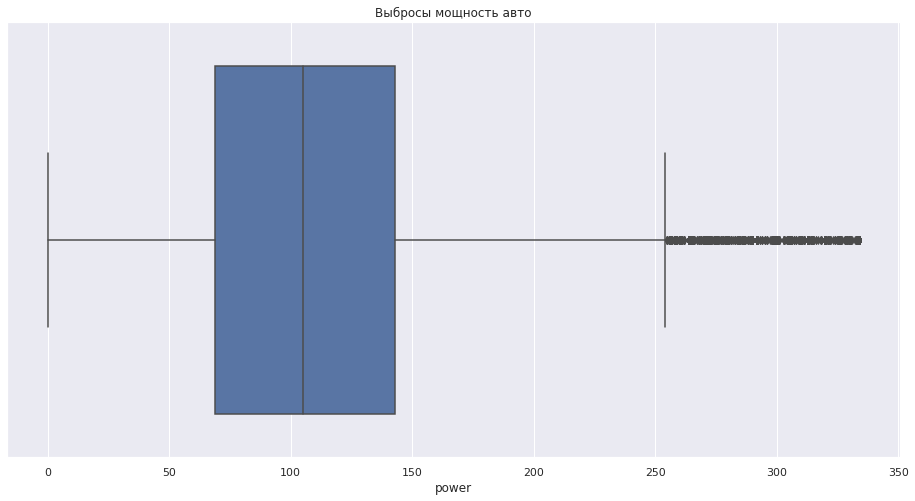

count    334734.000000
mean        106.862028
std          60.467990
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max         334.000000
Name: power, dtype: float64

In [27]:
r_q995 = data["power"].quantile(0.995)
d_q995 = data.query("power>@r_q995").shape[0]

print(f'Квантиль 0.995 мощность:{r_q995}')
print(f'Строк где мощность > {r_q995}: {d_q995}, всего {d_q995/origin_len:.2%} от ориг. датасета, удаляем.')
data.drop(data.loc[data['power']>r_q995].index, inplace=True)
print('Снова посмотрим на график выбросов:')
sns_boxplot(data['power'],'Выбросы мощность авто');
data['power'].describe()

In [28]:
p_zero = len(data.loc[data['power']==0])
print(f'Строк, где мощность равна нулю: {p_zero}, что составляет {p_zero/origin_len:.2%} от ориг. датасета.')

Строк, где мощность равна нулю: 35367, что составляет 9.98% от ориг. датасета.


**Видим очень большой процент данных с нулевой мощностью. Удалять эти строки не хотелось бы, попробуем заполнить данные.**

Мы понимаем, что у нас есть модель авто unknown, таких данных чуть больше 5%, поэтому.

Заполним нулевые данные мощности медианным значением по модели авто:

In [29]:
data.loc[(data['power'] == 0), 'power'] = None
data['power'] = data['power'].fillna(data.groupby('model')['power'].transform('median'))
p_zero = len(data.loc[data['power']==0])
print(f'Строк, где мощность равна нулю: {p_zero}, что составляет {p_zero/origin_len:.2%} от ориг. датасета.')

Строк, где мощность равна нулю: 0, что составляет 0.00% от ориг. датасета.


Получилось сразу избавиться от всех значений, т

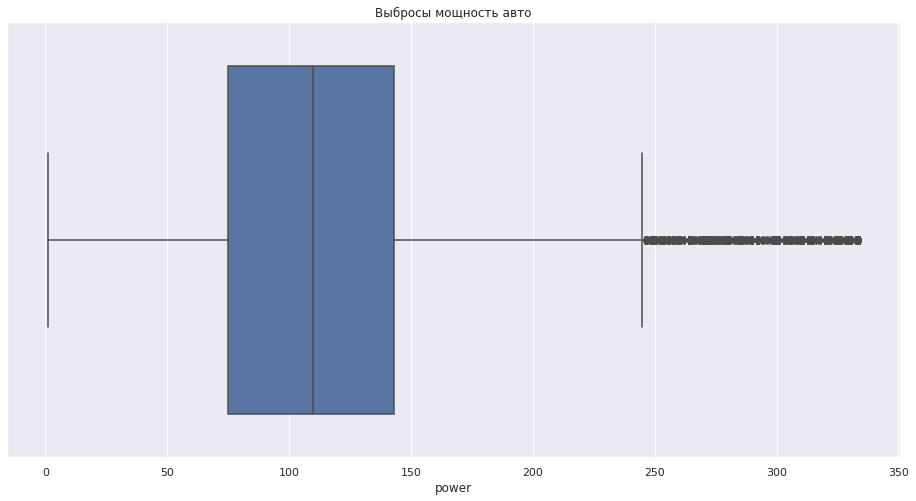

count    334733.00000
mean        118.20188
std          49.65162
min           1.00000
25%          75.00000
50%         110.00000
75%         143.00000
max         334.00000
Name: power, dtype: float64

In [30]:
sns_boxplot(data['power'],'Выбросы мощность авто');
data['power'].describe()

Однако, теперь у нас есть данные с мощностью в 1 л.с., что скорее всего ошибочно.

Посмотрим минимальный 0.005 квантиль и уберем строки где мощность меньше.

Квантиль 0.005 мощность:41.0
Строк где мощность < 41.0: 1484, всего 0.42% от ориг. датасета, удаляем.
Снова посмотрим на график выбросов и дискрайб:


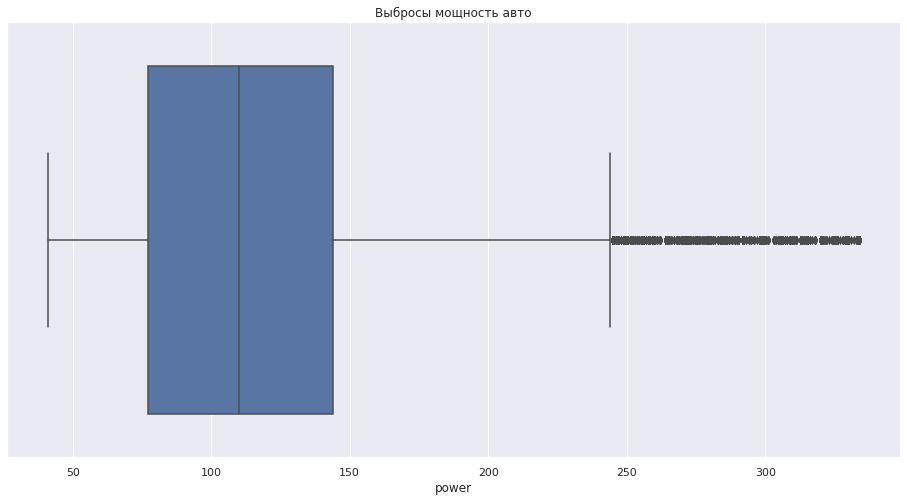

count    333249.000000
mean        118.605880
std          49.384386
min          41.000000
25%          77.000000
50%         110.000000
75%         144.000000
max         334.000000
Name: power, dtype: float64

In [31]:
r_q005 = data["power"].quantile(0.005)
d_q005 = data.query("power<@r_q005").shape[0]

print(f'Квантиль 0.005 мощность:{r_q005}')
print(f'Строк где мощность < {r_q005}: {d_q005}, всего {d_q005/origin_len:.2%} от ориг. датасета, удаляем.')
data.drop(data.loc[data['power']<r_q005].index, inplace=True)
print('Снова посмотрим на график выбросов и дискрайб:')
sns_boxplot(data['power'],'Выбросы мощность авто');
data['power'].describe()

С **аномальными** данными по мощности мы разобрались.

И вот теперь уже посмотрим на признак (**целевой**) price, т.к. видели в нём нулевые значения.

In [32]:
price_zero = data.query('price==0').shape[0]
print('Всего строк с нулевой ценой:',price_zero)
print(f'Это составляет {price_zero/len(data):.2%} датасета.')
print()
print('Describe:')
data['price'].describe()

Всего строк с нулевой ценой: 9586
Это составляет 2.88% датасета.

Describe:


count    333250.000000
mean       4428.093497
std        4501.400036
min           0.000000
25%        1099.000000
50%        2750.000000
75%        6450.000000
max       20000.000000
Name: price, dtype: float64

Восстановить данные нулевой цены мы никак не можем, т.к. случаи продаж обычно уникальны, и это целевой признак.

Да и данных с нулевой ценой допустимо мало для того чтобы их удалить.

In [33]:
data.drop(data.loc[data['price']==0].index, inplace=True)
data.describe()

,price,registration_year,power,kilometer
count,323664.000000,323664.000000,323664.000000,323664.000000
mean,4559.240935,2002.944779,118.756474,128756.858965
std,4501.643003,5.996054,49.467879,36959.171883
min,1.000000,1980.000000,41.000000,5000.000000
25%,1200.000000,1999.000000,77.000000,125000.000000
50%,2900.000000,2003.000000,110.000000,150000.000000
75%,6500.000000,2007.000000,144.000000,150000.000000
max,20000.000000,2016.000000,334.000000,150000.000000


Правда теперь мы видим, что есть price 1 евро, ... предположим, что машину могут продавать очень дешево, но не за 1 евро же. 

Соответственно удалим данные price, которых <1% по значению.

In [34]:
price_q = data["price"].quantile(0.01)
print(f'Квантиль 0.01 по целевому признаку цены: {price_q}')

Квантиль 0.01 по целевому признаку цены: 100.0


In [35]:
data.drop(data.loc[data['price']<price_q].index, inplace=True)

**Посмотрим финально на наши данные:**

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321349 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              321349 non-null  int64  
 1   vehicle_type       321349 non-null  object 
 2   registration_year  321349 non-null  int64  
 3   gearbox            321349 non-null  object 
 4   power              321349 non-null  float64
 5   model              321349 non-null  object 
 6   kilometer          321349 non-null  int64  
 7   fuel_type          321349 non-null  object 
 8   brand              321349 non-null  object 
 9   repaired           321349 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(5)
memory usage: 24.8+ MB


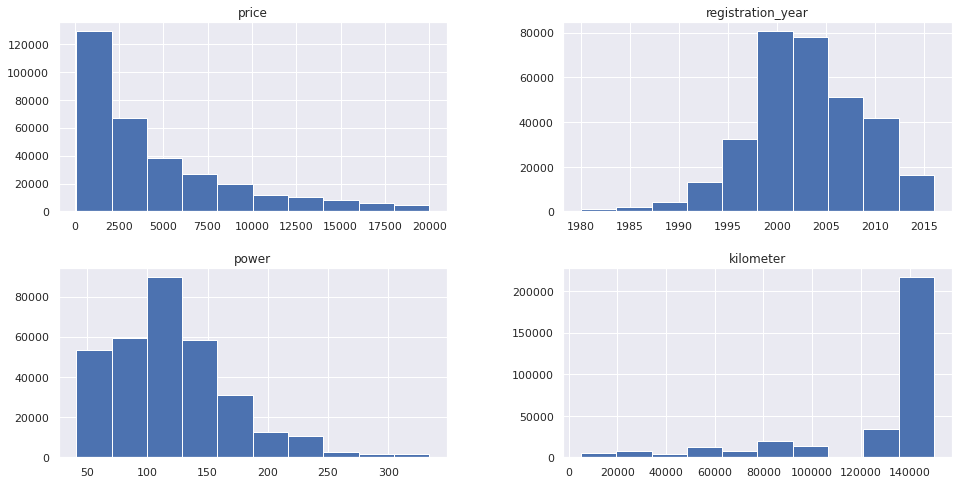

In [36]:
data.info();
data.hist();

Видим что числовые признаки распределены вполне нормально.

In [37]:
data.describe()

,price,registration_year,power,kilometer
count,321349.000000,321349.000000,321349.000000,321349.000000
mean,4591.874467,2002.964176,118.842234,128892.979284
std,4501.319531,5.982014,49.469420,36706.237274
min,100.000000,1980.000000,41.000000,5000.000000
25%,1200.000000,1999.000000,77.000000,125000.000000
50%,2900.000000,2003.000000,110.000000,150000.000000
75%,6500.000000,2007.000000,144.000000,150000.000000
max,20000.000000,2016.000000,334.000000,150000.000000


In [38]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,False
1,18300,coupe,2011,manual,190.0,unknown,125000,gasoline,audi,True
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,False
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,False
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,False


**И заодно обозначим и проверим на неявные дубли категориальные признаки:**

In [39]:
cat_feats = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

In [41]:
for col in cat_feats:
    print()
    print('Уникальные значения категориального признака',col)
    display(sorted(data[col].unique()))


Уникальные значения категориального признака vehicle_type


['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']


Уникальные значения категориального признака gearbox


['auto', 'manual', 'unknown']


Уникальные значения категориального признака model


['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 


Уникальные значения категориального признака fuel_type


['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol', 'unknown']


Уникальные значения категориального признака brand


['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

Неявных дубликатов не наблюдаю, на этом предобработку данных можно завершать.

In [42]:
print(f'Итого мы сохранили {len(data)/origin_len:.2%} данных оригинального датасета.')

Итого мы сохранили 90.68% данных оригинального датасета.


**Выводы:**

Мы проанализировали наши данные. И в ходе предобработки:
- избавились от дублей, лишних для модели признаков
- обработали отсутствующие данные
- обработали аномальные и нулевые значения



## Подготовка выборок для обучения моделей

Нам нужно построить одну из моделей LightGBM, еще мы проверим CatBoost, и как минимум одну — не бустинг, - это будет LinearRegression.

Модели LightGBM и CatBoost поддерживают работу с категориальными данными, а для LinearRegression мы данные закодируем и стандартизируем.

In [43]:
# создадим признаки и класс
features = data.drop(['price'], axis=1)
target = data['price']

# разобьем на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=12345)

# и сделаем валидационные выборки
features_train, features_val, target_train, target_val = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345
)

**Преобразуем данные для моделей бустинга и линейной регрессии**

Преобразования для линейной регрессии

In [44]:
# копируем признаки и класс
features_train_lin = features_train.copy()
features_val_lin = features_val.copy()
features_test_lin = features_test.copy()

In [45]:
# категориальные признаки
ohe_features = features_train_lin.select_dtypes(include='object').columns.to_list()
ohe_features

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

In [46]:
# численные признаки
num_features = features_train_lin.select_dtypes(exclude='object').columns.to_list()
num_features.remove('repaired')
num_features

['registration_year', 'power', 'kilometer']

In [47]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train_lin[ohe_features])

# добавляем закодированные признаки в features_train_lin
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train_lin[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_lin[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_lin = features_train_lin.drop(ohe_features, axis=1)

# делаем тоже самое с валидационной и тестовой выборками
features_val_lin[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_val_lin[ohe_features])
features_val_lin = features_val_lin.drop(ohe_features, axis=1)

features_test_lin[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_lin[ohe_features])
features_test_lin = features_test_lin.drop(ohe_features, axis=1)

In [48]:
# стандартизируем численные признаки
scaler = StandardScaler(); scaler.fit(features_train_lin[num_features])

features_train_lin[num_features] = scaler.transform(features_train_lin[num_features])
features_val_lin[num_features] = scaler.transform(features_val_lin[num_features])
features_test_lin[num_features] = scaler.transform(features_test_lin[num_features])

In [49]:
# проверим
features_train_lin.head()

,registration_year,power,kilometer,repaired,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
159900,-0.829798,-0.888524,0.575617,False,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
176602,1.173153,1.031437,-0.782916,False,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344043,-0.662886,-0.282220,0.575617,False,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270952,-1.831274,-0.888524,-3.364130,True,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
231487,-0.829798,-0.201380,0.575617,False,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Преобразования для бустинга

In [50]:
# преобразования для бустинга
features_train[cat_feats] = features_train[cat_feats].astype('category')
features_val[cat_feats] = features_val[cat_feats].astype('category')
features_test[cat_feats] = features_test[cat_feats].astype('category')

**Выводы:**
- разбили данные на тестовую, валидационную и обучающую выборки
- отдельно обработали (кодировали OHE категориальные и Scaler'ом числовые) признаки для модели LR
- обработали данные для моделей бустинга

## Обучение моделей

In [51]:
all_results = {}

### LinearRegression

In [72]:
model_name = 'LinearRegression'
# параметры для тестирования

print()
print(f"{model_name}")

model = LinearRegression()

start_learn = time.time()
model.fit(features_train_lin, target_train)
end_learn = time.time()

start_predict = time.time()
predictions = model.predict(features_val_lin)
end_predict = time.time()

rmse = mean_squared_error(target_val, predictions, squared=False)

#predictions_test = model.predict(features_test_lin)
#rmse_test = mean_squared_error(target_test, predictions_test, squared=False)
   
result = {
    'params':{},
    'result':{
        'rmse':rmse,
        #'rmse_test':rmse_test,
        'time_learn':(end_learn - start_learn),
        'time_predict':(end_predict - start_predict)
    },
    'model': model
}

all_results[model_name] = result


LinearRegression


In [73]:
print(f"Лучшая модель: RMSE {result['result']['rmse']}")
print(f"Скорость обучения: {result['result']['time_learn']}")
print(f"Скорость предсказания: {result['result']['time_predict']}")
print('Параметры:',result['params'])
print()
print(f"{model_name} показала минимальную RMSE {round(result['result']['rmse'],2)} на валидационной выборке")
#print(f"А на тестовых данных RMSE = {round(result['result']['rmse_test'],2)}")

Лучшая модель: RMSE 2488.312827113274
Скорость обучения: 25.991670846939087
Скорость предсказания: 0.22787761688232422
Параметры: {}

LinearRegression показала минимальную RMSE 2488.31 на валидационной выборке


### CatBoostRegressor

In [74]:
model_name = 'CatBoostRegressor'

p_iters = [50,100]
p_depth = [4,6]

pbar = tqdm(total=len(p_iters)*len(p_depth))

print()
print(f"{model_name}")

min_rmse = 10**10
for depth in p_depth:
    for iterations in p_iters:
    
        model = CatBoostRegressor(
            cat_features=cat_feats,
            loss_function='RMSE',
            iterations=iterations,
            depth=depth,
            random_seed=12345
        )

        start_learn = time.time()
        model.fit(features_train, target_train, verbose=False)
        end_learn = time.time()
        
        start_predict = time.time()
        predictions = model.predict(features_val)
        end_predict = time.time()

        rmse = mean_squared_error(target_val, predictions, squared=False)
        
        #predictions_test = model.predict(features_test)
        #rmse_test = mean_squared_error(target_test, predictions_test, squared=False)
        
        print()
        print('RMSE =',rmse)
        #print('RMSE TEST =',rmse_test)
        print(f'Параметры: depth={depth}, iterations={iterations}')
        print(f'Время обучения: {(end_learn - start_learn)}, Предсказания {(end_predict - start_predict)}')
        
        if(rmse<min_rmse):
            result = {
                'params':{
                    'iterations':iterations,
                    'depth':depth
                },
                'result':{
                    'rmse':rmse,
                    #'rmse_test':rmse_test,
                    'time_learn':(end_learn - start_learn),
                    'time_predict':(end_predict - start_predict)
                },
                'model': model
            }
        pbar.update()

print()
print()

all_results[model_name] = result

  0%|          | 0/4 [00:00<?, ?it/s]


CatBoostRegressor

RMSE = 1731.1866720310766
Параметры: depth=4, iterations=50
Время обучения: 2.713519334793091, Предсказания 0.04674124717712402

RMSE = 1674.0617308441736
Параметры: depth=4, iterations=100
Время обучения: 4.3056724071502686, Предсказания 0.04552960395812988

RMSE = 1660.329564103739
Параметры: depth=6, iterations=50
Время обучения: 3.746412515640259, Предсказания 0.05626821517944336

RMSE = 1613.3118465081418
Параметры: depth=6, iterations=100
Время обучения: 5.916425466537476, Предсказания 0.059606075286865234




In [75]:
print(f"Лучшая модель: RMSE {result['result']['rmse']}")
print(f"Скорость обучения: {result['result']['time_learn']}")
print(f"Скорость предсказания: {result['result']['time_predict']}")
print('Параметры:',result['params'])
print()
print(f"{model_name} показала минимальную RMSE {round(result['result']['rmse'],2)} на валидационной выборке")
#print(f"А на тестовых данных RMSE = {round(result['result']['rmse_test'],2)}")

Лучшая модель: RMSE 1613.3118465081418
Скорость обучения: 5.916425466537476
Скорость предсказания: 0.059606075286865234
Параметры: {'iterations': 100, 'depth': 6}

CatBoostRegressor показала минимальную RMSE 1613.31 на валидационной выборке


### LightGBM

In [76]:
model_name = 'LightGBM'

p_iters = [30,80]
p_depth = [10,20]

pbar = tqdm(total=len(p_iters)*len(p_depth))

print()
print(f"{model_name}")

min_rmse = 10**10
for depth in p_depth:
    for iterations in p_iters:
    
        model = lgb.LGBMRegressor(
            categorical_features=cat_feats,
            metric='rmse',
            num_iterations=iterations,
            max_depth=depth,
            random_seed=12345
        )

        start_learn = time.time()
        model.fit(features_train, target_train, verbose=False)
        end_learn = time.time()
        
        start_predict = time.time()
        predictions = model.predict(features_val)
        end_predict = time.time()

        rmse = mean_squared_error(target_val, predictions, squared=False)
        
        #predictions_test = model.predict(features_test)
        #rmse_test = mean_squared_error(target_test, predictions_test, squared=False)
        
        print()
        print('RMSE =',rmse)
        #print('RMSE TEST =',rmse_test)
        print(f'Параметры: max_depth={depth}, num_iterations={iterations}')
        print(f'Время обучения: {(end_learn - start_learn)}, Предсказания {(end_predict - start_predict)}')
        
        
        if(rmse<min_rmse):
            result = {
                'params':{
                    'num_iterations':iterations,
                    'max_depth':depth
                },
                'result':{
                    'rmse':rmse,
                    #'rmse_test':rmse_test,
                    'time_learn':(end_learn - start_learn),
                    'time_predict':(end_predict - start_predict)
                },
                'model': model
            }
        pbar.update()
        
print()
print()
all_results[model_name] = result

  0%|          | 0/4 [00:00<?, ?it/s]


LightGBM

RMSE = 1714.1223075274718
Параметры: max_depth=10, num_iterations=30
Время обучения: 23.43418002128601, Предсказания 0.2051863670349121

RMSE = 1579.8055385967643
Параметры: max_depth=10, num_iterations=80
Время обучения: 77.51256394386292, Предсказания 0.49736952781677246

RMSE = 1713.6964797220976
Параметры: max_depth=20, num_iterations=30
Время обучения: 26.982372045516968, Предсказания 0.2022237777709961

RMSE = 1578.8426052446046
Параметры: max_depth=20, num_iterations=80
Время обучения: 50.598188400268555, Предсказания 0.5113692283630371




In [77]:
print(f"Лучшая модель: RMSE {result['result']['rmse']}")
print(f"Скорость обучения: {result['result']['time_learn']}")
print(f"Скорость предсказания: {result['result']['time_predict']}")
print('Параметры:',result['params'])
print()
print(f"{model_name} показала минимальную RMSE {round(result['result']['rmse'],2)} на валидационной выборке")
#print(f"А на тестовых данных RMSE = {round(result['result']['rmse_test'],2)}")

Лучшая модель: RMSE 1578.8426052446046
Скорость обучения: 50.598188400268555
Скорость предсказания: 0.5113692283630371
Параметры: {'num_iterations': 80, 'max_depth': 20}

LightGBM показала минимальную RMSE 1578.84 на валидационной выборке


**Выводы**

Построили и протестировали модель LinearRegression
- показала минимальную RMSE 2488.31 на валидационной выборке

Построили и протестировали модель CatBoostRegressor
- показала минимальную RMSE 1613.31 на валидационной выборке в лучшем случае

Построили и протестировали модель LightGBM
- показала минимальную RMSE 1578.84 на валидационной выборке в лучшем случае

## Анализ моделей

**По условию задачи, значение метрики RMSE должно быть меньше 2500.**

Проанализируем полученные результаты.

**Посмотрим на результаты в виде таблицы:**

In [78]:
df_data = []
for model, model_result in all_results.items():
    df_data.append([
        model,
        round(model_result['result']['rmse'],2),
        str(round(model_result['result']['time_learn'],3))+' сек.',
        str(round(model_result['result']['time_predict'],3))+' сек.',
        str(model_result['params'])
    ])
df = pd.DataFrame(df_data, columns=['Модель', 'RMSE',
                                    'Скорость обучения', 'Скорость предсказания', 'Параметры'])
df = df.sort_values('RMSE',ascending=True)
df.style.hide_index()

Модель,RMSE,Скорость обучения,Скорость предсказания,Параметры
LightGBM,1578.840000,50.598 сек.,0.511 сек.,"{'num_iterations': 80, 'max_depth': 20}"
CatBoostRegressor,1613.310000,5.916 сек.,0.06 сек.,"{'iterations': 100, 'depth': 6}"
LinearRegression,2488.310000,25.992 сек.,0.228 сек.,{}


**Как мы видим:**
- Модель LinearRegression не подходит по условию задачи, превышена ошибка.
- Модели CatBoostRegressor и LightGBM не превысили ошибку (2500), подходят нам.

**Как мы видим, при незначительно меньшей ошибке модель LightGBM значительно дольше учится, хоть и предсказывает быстрее.**

**Выбираем для заказчика с учетом всех показателей:**

Модель CatBoostRegressor
- показала минимальную RMSE 1613.31 на валидационной выборке
- скорость обучения 5.916 сек. (против 50.598 сек. у LightGBM)
- скорость предсказания 0.06 сек. (против 0.511 сек. у LightGBM)

*Следует учитывать, что от запуска к запуску данные времени обучения/предсказания могут отличаться, но общую динамику мы видим вполне отчетливо, сравнивая модели.*

## Тестирование лучшей модели

После анализа моделей и выбора лучшей - протестируем её на тестовой выборке.

In [79]:
# берем сохраненную топ-модель
top_model = all_results['CatBoostRegressor']['model']

In [80]:
# делаем предсказание по тестовой выборке
start_predict = time.time()
predictions_test = top_model.predict(features_test)
end_predict = time.time()

# записываем показатели
top_model_predict_time = (end_predict - start_predict)
top_model_rmse = mean_squared_error(target_test, predictions_test, squared=False)

In [82]:
print('На тестовой выборке лучшая модель CatBoostRegressor показала:')
print(f'Скорость предсказания: {top_model_predict_time:.2f} сек.')
print(f'RMSE: {top_model_rmse:.2f}')

На тестовой выборке лучшая модель CatBoostRegressor показала:
Скорость предсказания: 0.09 сек.
RMSE: 1623.81


**Выбранная лучшая модель отлично показала себя на тестовой выборке, быстро предсказывает, ошибка гораздо ниже максимально допустимой по условию задачи.**

## Общий вывод

**Цель проекта:** Нам нужно построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**Мы выполнили работы:**

1. Загрузили и изучили данные

- ознакомились с данными
- избавились от дублей, лишних для модели признаков
- обработали отсутствующие данные
- обработали аномальные и нулевые значения
- провели анализ данных
    

2. Подготовили выборки для обучения моделей.

- разбили данные на тестовую, валидационную и обучающую выборки
- отдельно обработали (кодировали OHE категориальные и Scaler'ом числовые) признаки для модели LR
- обработали данные для моделей бустинга


3. Обучили разные модели, протестировав их и на валидационной выборке

    Построили и протестировали модель LinearRegression
    - показала минимальную RMSE 2488.31 на валидационной выборке

    Построили и протестировали модель CatBoostRegressor
    - показала минимальную RMSE 1613.31 на валидационной выборке в лучшем случае

    Построили и протестировали модель LightGBM
    - показала минимальную RMSE 1578.84 на валидационной выборке в лучшем случае


4. Проанализировали время обучения, время предсказания и качество моделей.

- Опираясь на критерии заказчика, выбрали лучшую модель:

    **Модель CatBoostRegressor с RMSE = 1613.31 на валидационной выборке.**

    Скорость обучения: 5.916 сек., предсказания: 0.06 сек.

    *Параметры: {'iterations': 100, 'depth': 6}*


5. Протестировали выбранную лучшую модель на тестовой выборке

- На тестовой выборке лучшая модель CatBoostRegressor показала:
    - Скорость предсказания: 0.09 сек.
    - RMSE: 1623.81

Дополнительно, следует учесть, что скорость обучения и работы модели зависит в том числе и от технических характеристик устройства и от ПО, на котором всё запускается.